# Ganopolski 2024- Toward generalized Milankovitch theory 


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

import numpy as np
from copy import copy
import matplotlib.pyplot as plt

In [2]:
import paleobeasts as pb
from paleobeasts.signal_models import g24

# Model 3
(From Ganopolski et al. 2024)

## Primary Equations
Change in ice volume is a function of the state of the system (k), the ice volume (v), and time (t). The equation is given by: 

\begin{equation}
\frac{dv}{dt}=
    \begin{cases}
        \frac{(v_{e} - v)}{t_{1}} & \text{  if } k=1\\
        \frac{(-v_{c})}{t_{2}} & \text{  if } k=2
    \end{cases}
\end{equation}

The state of the system ($k$) is determined by the following conditions:
- transition from a glacial (k=1) to deglaciation regime (k = 2) occurs if three conditions are met:
    - v > $v_c$, 
    - dfdt > 0, 
    - f > 0
- The transition from deglaciation (k=2) to glacial (k=1) regime occurs if:
    - f < $f_1$ (where $f_1$ is the insolation threshold for glacial inception)
The interglacial state formally belongs to the deglaciation regime.

## Forcing Equation
\begin{align}
f = A * (1 + \epsilon * \sin(2 \pi * t / T1)) * \cos(2 \pi * t / T2)
\end{align}

`A` = magnitude of forcing in Wm−2
`eps` = nondimensional magnitude of amplitude modulation

### If k=1...
\begin{align}
\frac{dv}{dt} = \frac{(v_{e} - v)}{t_{1}}
\end{align}

#### Equilibrium ice volume $v_{e}$ given a glacial state:
Where $v_{e}$ is the ice volume of the equilibrium state to which the system is attracted:

\begin{equation}
v_{e}=
    \begin{cases}
        v_{g} & \text{  if } f<f_{1} \text{ or } f_{1}<f<f_{2} \text{ and } v>v_{u}\\
        v_{i} & \text{  if } f>f_{2} \text{ or } f_{1}<f<f_{2} \text{ and } v<v_{u}
    \end{cases}
\end{equation}

$f_1$ = insolation threshold for glacial inception (pinned at -20 to -15 W/m^2)
$t_1$ = relaxation timescale for glacial inception (in kyr)
$f_2$ = insolation threshold for deglaciation inception (tunable; positive)

If the forcing is less than the glacial inception threshold ($f_{1}$), the equilibrium ice volume is equilibrium glacial state $v_{g}$ ice volume. If the forcing is greater than the deglaciation threshold ($f_{2}$), the equilibrium ice volume is the equilibrium interglacial ice volume $v_{i}$. 

If the forcing is between the glacial inception threshold ($f_{1}$) and the deglaciation threshold ($f_{2}$), the equilibrium ice volume is determined by whether the current ice volume is greater or less than $v_{u}$, the unstable equilibrium ice volume. Greater and the system will be attracted to the glacial value, less and the system will be attracted to the interglacial value.  

\begin{align}
v_{u} = 1 - \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
\end{align}

The values of $v_{g}$ and $v_{i}$ are given by:
\begin{align}
v_{g} = 1 + \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
v_{i} = 0
\end{align}

#### 

### if k = 2...

\begin{align}
\frac{dv}{dt} = \frac{(-v_{c})}{t_{2}}
\end{align}

$v_{c}$  = value for critical ice volume; controls the dominant periodicity and degree of asymmetry of glacial cycles
$t_2$ = relaxation timescale for deglaciation (in kyr)

$v_{c}$ is a tunable parameter. Ganopolski 2024, includes figures based on a constant value of $v_{c}$ values of 1.2, 1.33 and 1.47 as well as a time dependent value used for exploring the mid Pleistocene transition.

## Code
Note: getting the figure to look like the one in the paper is a bit tricky. The system seems to be fairly sensitive to interval of integration and timestep.

In [8]:
import os
from pathlib import Path
proj_dir = Path(os.getcwd()).parent.parent
proj_dir

PosixPath('/Users/jlanders/PycharmProjects/PaleoBeasts')

In [15]:
import pandas as pd
orbital_full = pd.read_csv(proj_dir/'data/insolation.csv', index_col=0)

Index(['kyear', 'insol_65N_d172', 'insol_65N_d233'], dtype='object')


,kyear,insol_65N_d172,insol_65N_d233
3801,-1199.0,484.677080,341.481326
3802,-1198.0,482.475881,336.273798
3803,-1197.0,482.204008,329.295991
3804,-1196.0,483.716534,321.195729
3805,-1195.0,486.798563,312.612709


In [126]:
orb_forcing = pb.Forcing(orbital_full['insol_65N_d172'].values-orbital_full['insol_65N_d172'].mean(), time=orbital_full['kyear'], interpolation='cubic')

data is an array


In [127]:
f1 = -16 #insolation threshold for glacial inception
f2 = 16 #insolation threshold for deglaciation inception
vc = 1.4 #critical ice volume
t1 = 30 #relaxation timescale for glacial inception
t2 = 10 #relaxation timescale for deglaciation

In [129]:
dfdt = pb.utils.utilities.make_derivative_func(method='numpy', derivative=None, data=orb_forcing.data, time=orb_forcing.time)

In [143]:
# Initialize the model
model3 = g24.Model3(forcing=orb_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)
model3.dfdt = dfdt


### Try a few different timestep sizes
It's not clear to me why the model is so sensitive to timestep. I believe the paper says 40kyr, but dt=40kyr won't resolve the small peaks, so I assume that the timestep is actually smaller than that. I found that 6.5 kyr was the timestep that produced a reasonable replication of the paper figure.

In [245]:
length = 1000 #length of simulation in kyr 1003
t_i = 0 #start time
t_f = t_i+length #end time
model3.time_util= lambda x: -5000+ (5000-t_f) +x

delta_ts=[1,2,4,8] #timestep
v_i= 0 #initial ice volume
k_i = 1 #initial state

In [246]:
# Initialize the model
euler_model3s = {}
for dt in delta_ts:
    model3_euler = copy(model3)
    model3_euler.integrate((t_i, t_f), [v_i, k_i], method='euler',kwargs={'dt':dt})
    euler_model3s[dt]=model3_euler


/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:162: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:179: RuntimeWarning: invalid value encountered in sqrt
  """


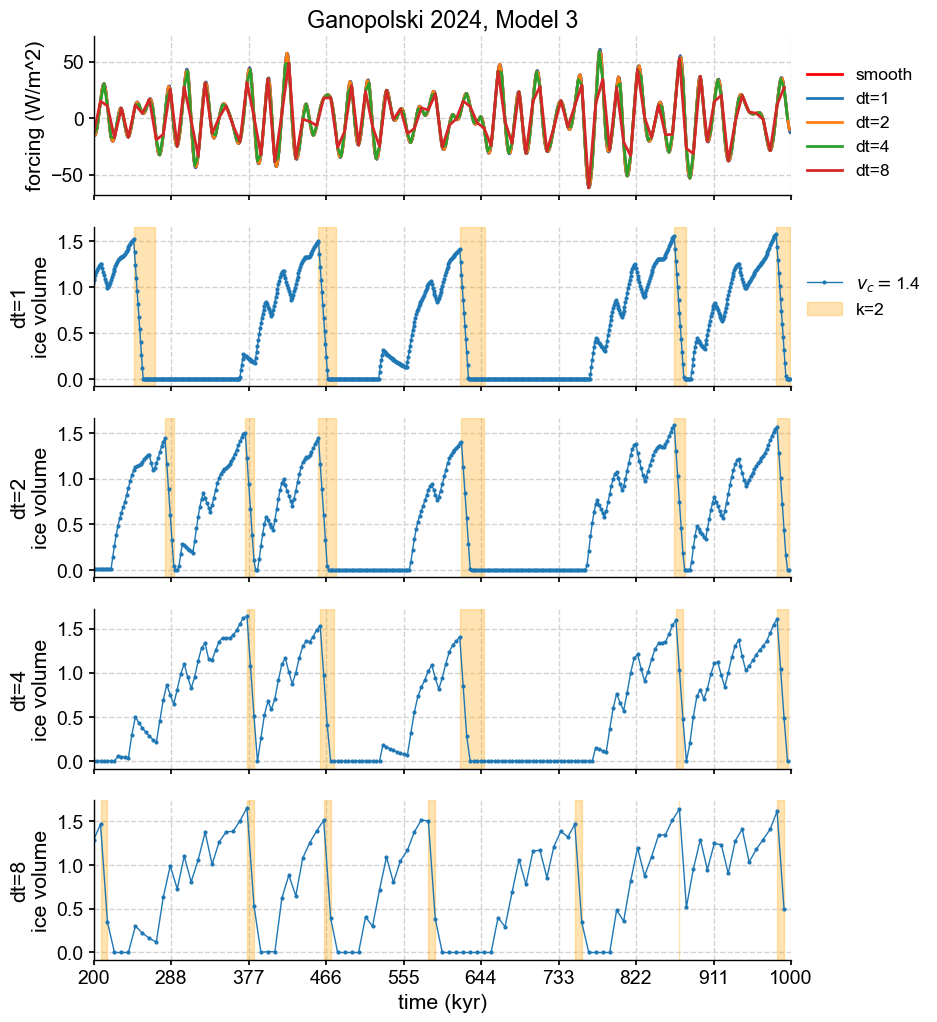

In [247]:
end_kya=0
start_kya=800

model_sol = euler_model3s[delta_ts[0]]

t_range = np.arange(max(model_sol.solution.t)-start_kya, max(model_sol.solution.t)-end_kya, 1)
ticks = np.linspace(max(model_sol.solution.t)-start_kya, max(model_sol.solution.t)-end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(delta_ts)+1, 1, sharex=True, figsize=(9, 12))

for ik, dt in enumerate(delta_ts):
    model_sol = euler_model3s[dt]
    time = model_sol.time#solution.t#['t_arr']
    k_arr = model_sol.state_variables['k']
    model_sol_y = model_sol.state_variables['v']#model_sol.solution.y[:,0]
    
    #DataFrame and sort by 'Time'
    df = pd.DataFrame({'Time': time, 'k': k_arr}).sort_values('Time')
    # Filter out data where 'Time' is less than min(t_range)
    df = df[df['Time'] > min(t_range)]
    # Identify where 'k' changes and calculate 'start' and 'end'
    df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
    df['end'] = (df['k'] == 2) & (df['k'].shift(-1) != 2)
    
    # Extract intervals
    intervals = [(start, end) for start, end in zip(df.loc[df['start'], 'Time'], df.loc[df['end'], 'Time'])]
    
    # Handling case where last interval does not end within the data range
    if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
        intervals.append((df.loc[df['start'], 'Time'].iloc[-1], df.iloc[-1]['Time']))

    model_forcing = model_sol.forcing.get_forcing(model_sol.time_util(time))
    label=','.join([r'$v_c=$'+str(model_sol.vc)])
    ax[ik+1].plot(time, model_sol_y, linewidth=1, marker='o', markersize=2, label=label)
        
    if len(intervals)>0:
        for ip, interval in enumerate(intervals):
            if ip==0:
                label='k=2'
            else:
                label=None
            ax[ik+1].axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=label)
    ax[ik+1].set_xlim([max(model_sol.solution.t)-start_kya, max(model_sol.solution.t)-end_kya])
    if ik == 1:
        ax[ik+1].legend(loc='upper left', bbox_to_anchor=(1,2))
    if ik == 0:
        ax[0].plot(t_range, model_sol.forcing.get_forcing(model_sol.time_util(t_range)), label='smooth', color='red')
    ax[0].plot(time, model_forcing, linewidth=2, label='dt={}'.format(dt))
    

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik+1].set_xticks(ticks)
    # ax[ik+1].set_ylim([-1,1.9])
    ax[ik+1].set_ylabel('\n'.join(['dt={}'.format(dt),model_sol.variable_name]))
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
ax[0].set_title('Ganopolski 2024, Model 3')
ax[0].legend(loc = 'upper left', bbox_to_anchor=(1,.9))
# plt.savefig('figures/g24_model3_euler_vc1p47.png')